<a href="https://colab.research.google.com/github/Sam-Coding77/8086-8088-Simulator/blob/main/MoViNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install av
! wget https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
# Download HMDB51 data and splits from serre lab website
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 17.0 MB/s eta 0:00:00
--2025-02-17 10:46:50--  https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102 (3.0K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]   3.03K  --.-KB/s    in 0s      

2025-02-17 10:46:50 (43.7 MB/s) - ‘transforms.py’ saved [3102/3102]

--2025-02-17 10:46:50--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connecte

In [2]:
!pip install git+https://github.com/Atze00/MoViNet-pytorch.git


  Cloning https://github.com/Atze00/MoViNet-pytorch.git to /tmp/pip-req-build-t9271fzd
  Running command git clone --filter=blob:none --quiet https://github.com/Atze00/MoViNet-pytorch.git /tmp/pip-req-build-t9271fzd
  Resolved https://github.com/Atze00/MoViNet-pytorch.git to commit c2d1edf48fc6c5259707f9d833f22171b4f63493
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0

In [3]:
# Extract and organize video data..
! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar
! rm hmdb51_org.rar
! mv *.rar video_data
import os
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    os.system("mkdir -p video_data/" + foldername)
    os.system("unrar e video_data/"+ files + " video_data/"+foldername)

! rm video_data/*.rar



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from test_train_splits.rar

Extracting  test_train_splits/brush_hair_test_split1.txt                   0%  OK 
Extracting  test_train_splits/brush_hair_test_split2.txt                   1%  OK 
Extracting  test_train_splits/brush_hair_test_split3.txt                   1%  OK 
Extracting  test_train_splits/cartwheel_test_split1.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split2.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split3.txt                    3%  OK 
Extracting  test_train_splits/catch_test_split1.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split2.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split3.txt                        5%  OK 
Extracting  test_train_splits/chew_test_split1.txt       

In [4]:
import time
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch
import transforms as T
from movinets import MoViNet
from movinets.config import _C

torch.manual_seed(97)
num_frames = 16 # 16
clip_steps = 2
Bs_Train = 16
Bs_Test = 16

transform = transforms.Compose([

                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 T.RandomHorizontalFlip(),
                                 #T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                 T.RandomCrop((172, 172))])
transform_test = transforms.Compose([
                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 #T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                 T.CenterCrop((172, 172))])

hmdb51_train = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=True,
                                                transform=transform, num_workers=2)


hmdb51_test = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=False,
                                                transform=transform_test, num_workers=2)
train_loader = DataLoader(hmdb51_train, batch_size=Bs_Train, shuffle=True)
test_loader  = DataLoader(hmdb51_test, batch_size=Bs_Test, shuffle=False)

100%|██████████| 423/423 [01:38<00:00,  4.28it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/video_utils.py:219: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(
100%|██████████| 423/423 [01:41<00:00,  4.16it/s]


In [5]:
def train_iter(model, optimz, data_load, loss_val):
    samples = len(data_load.dataset)
    model.train()
    model.cuda()
    model.clean_activation_buffers()
    optimz.zero_grad()
    for i, (data,_ , target) in enumerate(data_load):
        out = F.log_softmax(model(data.cuda()), dim=1)
        loss = F.nll_loss(out, target.cuda())
        loss.backward()
        optimz.step()
        optimz.zero_grad()
        model.clean_activation_buffers()
        if i % 50 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_load)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_val.append(loss.item())

def evaluate(model, data_load, loss_val):
    model.eval()

    samples = len(data_load.dataset)
    csamp = 0
    tloss = 0
    model.clean_activation_buffers()
    with torch.no_grad():
        for data, _, target in data_load:
            output = F.log_softmax(model(data.cuda()), dim=1)
            loss = F.nll_loss(output, target.cuda(), reduction='sum')
            _, pred = torch.max(output, dim=1)

            tloss += loss.item()
            csamp += pred.eq(target.cuda()).sum()
            model.clean_activation_buffers()
    aloss = tloss / samples
    loss_val.append(aloss)
    print('\nAverage test loss: ' + '{:.4f}'.format(aloss) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(samples) + ' (' +
          '{:4.2f}'.format(100.0 * csamp / samples) + '%)\n')

def train_iter_stream(model, optimz, data_load, loss_val, n_clips = 2, n_clip_frames=8):
    """
    In causal mode with stream buffer a single video is fed to the network
    using subclips of lenght n_clip_frames.
    n_clips*n_clip_frames should be equal to the total number of frames presents
    in the video.

    n_clips : number of clips that are used
    n_clip_frames : number of frame contained in each clip
    """
    #clean the buffer of activations
    samples = len(data_load.dataset)
    model.cuda()
    model.train()
    model.clean_activation_buffers()
    optimz.zero_grad()

    for i, (data,_, target) in enumerate(data_load):
        data = data.cuda()
        target = target.cuda()
        l_batch = 0
        #backward pass for each clip
        for j in range(n_clips):
          output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
          loss = F.nll_loss(output, target)
          _, pred = torch.max(output, dim=1)
          loss = F.nll_loss(output, target)/n_clips
          loss.backward()
        l_batch += loss.item()*n_clips
        optimz.step()
        optimz.zero_grad()

        #clean the buffer of activations
        model.clean_activation_buffers()
        if i % 50 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_load)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(l_batch))
            loss_val.append(l_batch)

def evaluate_stream(model, data_load, loss_val, n_clips = 2, n_clip_frames=8):
    model.eval()
    model.cuda()
    samples = len(data_load.dataset)
    csamp = 0
    tloss = 0
    with torch.no_grad():
        for data, _, target in data_load:
            data = data.cuda()
            target = target.cuda()
            model.clean_activation_buffers()
            for j in range(n_clips):
              output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
              loss = F.nll_loss(output, target)
            _, pred = torch.max(output, dim=1)
            tloss += loss.item()
            csamp += pred.eq(target).sum()

    aloss = tloss /  len(data_load)
    loss_val.append(aloss)
    print('\nAverage test loss: ' + '{:.4f}'.format(aloss) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(samples) + ' (' +
          '{:4.2f}'.format(100.0 * csamp / samples) + '%)\n')

In [6]:
N_EPOCHS = 1

model = MoViNet(_C.MODEL.MoViNetA0, causal = True, pretrained = True )
start_time = time.time()

trloss_val, tsloss_val = [], []
model.classifier[3] = torch.nn.Conv3d(2048, 51, (1,1,1))
optimz = optim.Adam(model.parameters(), lr=0.00005)
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_iter_stream(model, optimz, train_loader, trloss_val)
    evaluate_stream(model, test_loader, tsloss_val)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Downloading: "https://github.com/Atze00/MoViNet-pytorch/blob/main/weights/modelA0_stream_statedict_v3?raw=true" to /root/.cache/torch/hub/checkpoints/modelA0_stream_statedict_v3
100%|██████████| 14.5M/14.5M [00:00<00:00, 221MB/s]


Epoch: 1


/usr/local/lib/python3.11/dist-packages/torchvision/io/video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


[    0/ 7520 (  0%)]  Loss: 3.9192
[  800/ 7520 ( 11%)]  Loss: 3.4507
[ 1600/ 7520 ( 21%)]  Loss: 2.6133
[ 2400/ 7520 ( 32%)]  Loss: 2.6334
[ 3200/ 7520 ( 43%)]  Loss: 1.9658
[ 4000/ 7520 ( 53%)]  Loss: 1.8465
[ 4800/ 7520 ( 64%)]  Loss: 1.1569
[ 5600/ 7520 ( 74%)]  Loss: 1.8287
[ 6400/ 7520 ( 85%)]  Loss: 1.0312
[ 7200/ 7520 ( 96%)]  Loss: 1.2799

Average test loss: 1.2812  Accuracy: 2142/ 2945 (72.73%)

Execution time: 1109.74 seconds


In [9]:
import os

# Get class names from video_data directory
video_data_path = "video_data"  # Update if needed
class_names = sorted(os.listdir(video_data_path))  # Sort to ensure consistent ordering

print("Classes:", class_names)  # Check class names


Classes: ['brush_hair', 'cartwheel', 'catch', 'chew', 'clap', 'climb', 'climb_stairs', 'dive', 'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing', 'flic_flac', 'golf', 'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball', 'kiss', 'laugh', 'pick', 'pour', 'pullup', 'punch', 'push', 'pushup', 'ride_bike', 'ride_horse', 'run', 'shake_hands', 'shoot_ball', 'shoot_bow', 'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 'stand', 'swing_baseball', 'sword', 'sword_exercise', 'talk', 'throw', 'turn', 'walk', 'wave']


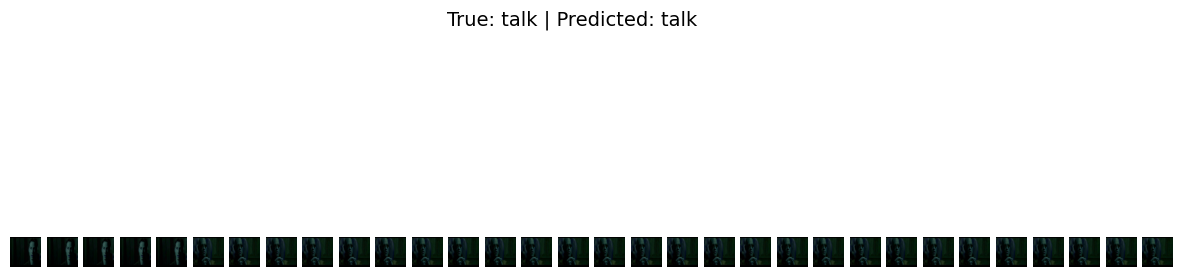

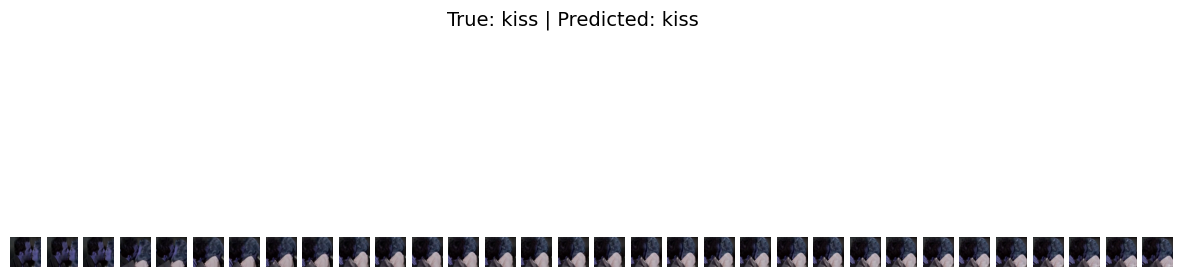

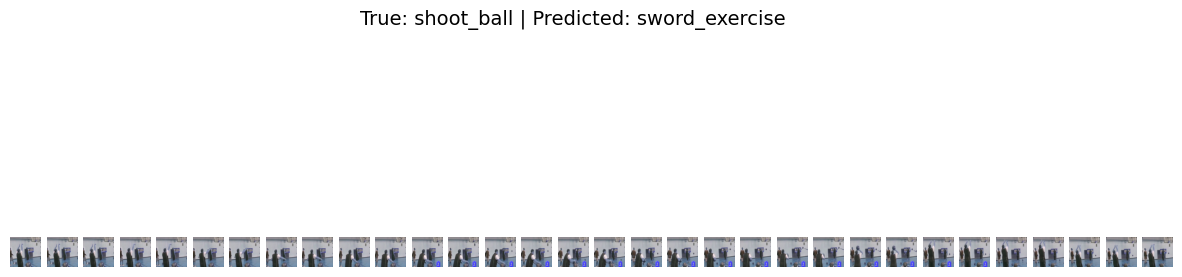

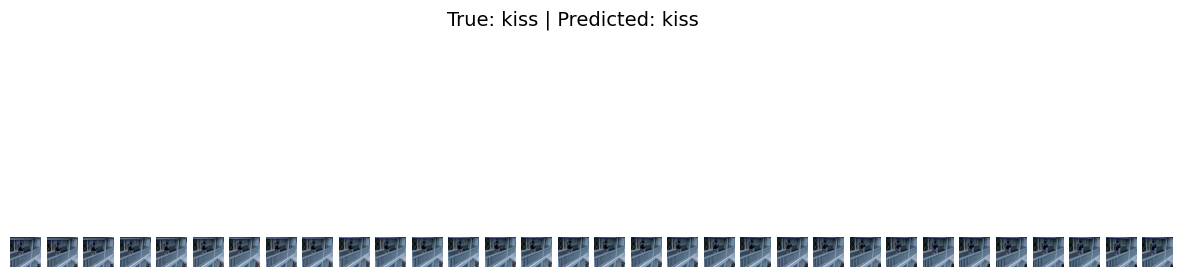

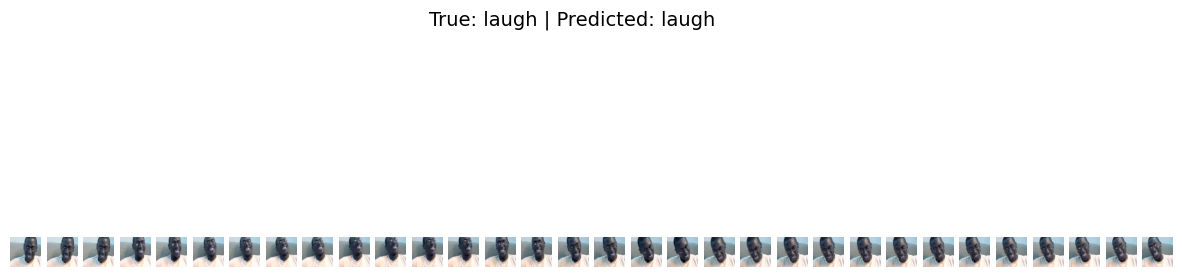

In [26]:
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def visualize_random_predictions(model, data_loader, class_names, num_samples=5, num_frames=8):
    """
    Randomly selects videos from different classes and visualizes their predictions.
    """
    model.eval()
    model.cuda()

    transform = transforms.ToPILImage()

    # Get all available dataset indices and shuffle them
    dataset_indices = list(range(len(data_loader.dataset)))
    random.shuffle(dataset_indices)  # Shuffle indices

    selected_samples = dataset_indices[:num_samples]  # Pick `num_samples` random videos

    count = 0
    with torch.no_grad():
        for idx in selected_samples:  # Load videos using random indices
            video, _, target = data_loader.dataset[idx]  # Get random video sample
            video_clip = video.unsqueeze(0).cuda()  # Add batch dimension
            true_label = target  # Ground truth label

            model.clean_activation_buffers()  # Reset MoViNet activation buffer
            output = model(video_clip)  # Get prediction
            _, pred = torch.max(output, dim=1)  # Get predicted class
            pred_label = pred.item()

            # Extract frames from video clip
            video_frames = video_clip.cpu().squeeze(0).numpy()  # Shape: (C, Frames, H, W)
            video_frames = np.transpose(video_frames, (1, 2, 3, 0))  # Convert to (Frames, H, W, C)

            # Select `num_frames` evenly spaced frames
            selected_frames = np.linspace(0, video_frames.shape[0] - 1, num_frames).astype(int)

            fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
            for j, frame_idx in enumerate(selected_frames):
                frame = video_frames[frame_idx]
                frame = (frame * 255).astype(np.uint8)  # Convert to image range
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format
                axs[j].imshow(frame)
                axs[j].axis('off')

            plt.suptitle(f"True: {class_names[true_label]} | Predicted: {class_names[pred_label]}", fontsize=14)
            plt.show()

            count += 1
            if count >= num_samples:
                break

# Get class names from video_data
video_data_path = "video_data"
class_names = sorted(os.listdir(video_data_path))  # Extract actual class names

# Visualize predictions from 5 random test videos across different classes
visualize_random_predictions(model, test_loader, class_names, num_samples=5, num_frames=32)


## Inference Speed

In [25]:
import time
import torch

def measure_inference_speed(model, input_tensor, num_iterations=100):
    """
    Measures the inference speed (FPS and Latency) of a given model.
    - model: The MoViNet model.
    - input_tensor: A single video/frame input.
    - num_iterations: Number of iterations to average inference time.

    Returns:
    - FPS (Frames Per Second)
    - Latency per frame (ms)
    """
    model.eval()
    model.cuda()

    # Warm-up the model for accurate measurements
    for _ in range(10):
        _ = model(input_tensor.cuda())

    start_time = time.time()

    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.cuda())

    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_inference = total_time / num_iterations
    fps = 1 / avg_time_per_inference

    print(f"Average Latency per Frame: {avg_time_per_inference * 1000:.2f} ms")
    print(f"Frames Per Second (FPS): {fps:.2f}")

# Example Input (Single Frame) for MoViNet (1 batch, 3 channels, 1 frame, 172x172)
input_tensor = torch.randn(1, 3, 32, 172, 172).cuda()

# Measure Speed
measure_inference_speed(model, input_tensor)


Average Latency per Frame: 33.96 ms
Frames Per Second (FPS): 29.45


## GPU Memory Usage

In [21]:
import torch

def measure_memory_usage(model, input_tensor):
    """
    Measures GPU memory usage during inference.
    """
    torch.cuda.reset_max_memory_allocated()
    model.eval()
    model.cuda()

    with torch.no_grad():
        _ = model(input_tensor.cuda())

    max_memory = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MB
    print(f"Max GPU Memory Used: {max_memory:.2f} MB")

# Measure Memory Usage
measure_memory_usage(model, input_tensor)


Max GPU Memory Used: 316.19 MB


/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
N_EPOCHS = 1

model = MoViNet(_C.MODEL.MoViNetA0, causal = False, pretrained = True )
start_time = time.time()

trloss_val, tsloss_val = [], []
model.classifier[3] = torch.nn.Conv3d(2048, 51, (1,1,1))
optimz = optim.Adam(model.parameters(), lr=0.00005)
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_iter(model, optimz, train_loader, trloss_val)
    evaluate(model, test_loader, tsloss_val)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/ 7519 (  0%)]  Loss: 3.9084
[  800/ 7519 ( 11%)]  Loss: 3.5596
[ 1600/ 7519 ( 21%)]  Loss: 3.4118
[ 2400/ 7519 ( 32%)]  Loss: 2.0215
[ 3200/ 7519 ( 43%)]  Loss: 1.8647
[ 4000/ 7519 ( 53%)]  Loss: 1.2905
[ 4800/ 7519 ( 64%)]  Loss: 1.4333
[ 5600/ 7519 ( 74%)]  Loss: 1.5478
[ 6400/ 7519 ( 85%)]  Loss: 0.8748
[ 7200/ 7519 ( 96%)]  Loss: 1.6601

Average test loss: 1.4166  Accuracy: 1893/ 2944 (64.30%)

Execution time: 1315.45 seconds
